### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL.Image as Image
from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

### Set up data

In [47]:
BASE_PREFIX = 'data/' # change to your data folder
TRAIN_PREFIX = BASE_PREFIX + 'train/'
TEST_PREFIX = BASE_PREFIX + 'test/'
MODEL_SAVE_PATH = 'trained_models/model2.pt'
VALIDATION_RECTS = [(1100, 3500, 700, 950),  # validation patch to remove from each training fragment
                    (2200, 10800, 700, 950),
                    (2100, 4400, 700, 950)]
BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 32   # Number of slices in the z direction
TRAINING_EPOCHS = 30000
VALIDATION_EPOCHS= 1000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel   

  0%|                                                                                                              | 0/32 [00:00<?, ?it/s]/home/pvk/.local/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]


CPU times: user 29.2 s, sys: 29.8 s, total: 59 s
Wall time: 37.1 s


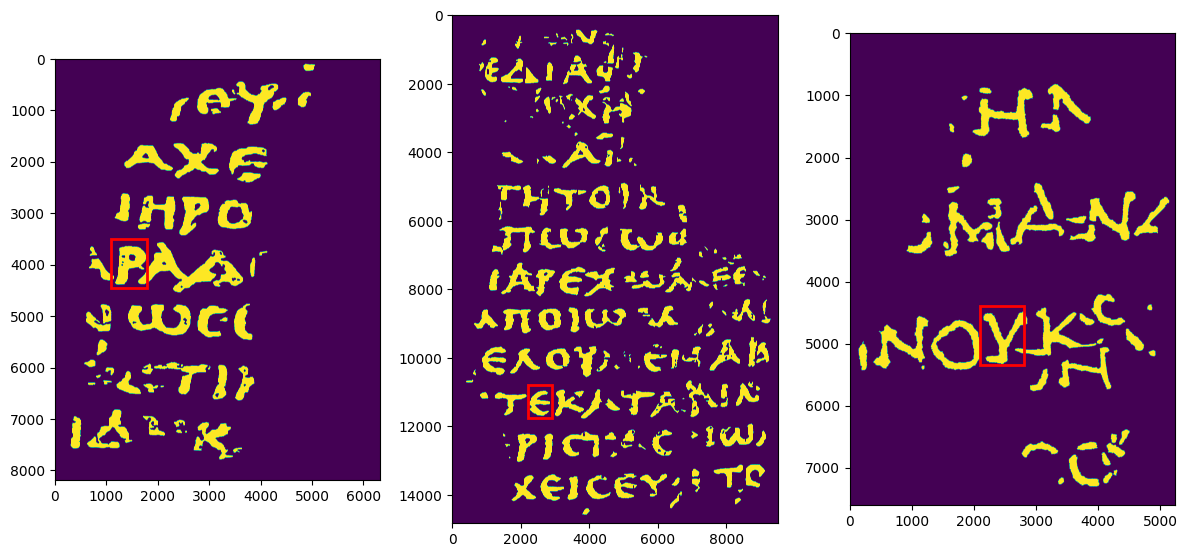

In [4]:
%%time
# Generate masks for all three training sets, and display them
# Note -- this is all done on the CPU -- we'll put the data on the GPU during training
train_dsets = []
val_dsets = []

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

for i in range(3):
    PREFIX = TRAIN_PREFIX + f"{i+1}/"
    ax = axs[i]
    # turn images to tensors
    images = [
        np.array(Image.open(filename), dtype=np.float32)/65535.0
        for filename in tqdm(sorted(glob.glob(PREFIX + "surface_volume/*.tif"))
                             [Z_START:Z_START+Z_DIM])
    ]
    image_stack = torch.stack([torch.from_numpy(image) for image in images], 
                              dim=0)
    
    # get mask and labels
    mask = np.array(Image.open(PREFIX + "mask.png").convert('1'))
    label = torch.from_numpy(
        np.array(Image.open(PREFIX + "inklabels.png"))
    ).gt(0).float()
    
    # define validation rectangle
    rect = VALIDATION_RECTS[i]
    
    # plot inklabels and validation rectangle
    ax.imshow(label)
    patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

    # Split our dataset into train and val. The pixels inside the rect are the 
    # val set, and the pixels outside the rect are the train set.
    # Adapted from https://www.kaggle.com/code/jamesdavey/100x-faster-pixel-coordinate-generator-1s-runtime
    # Create a Boolean array of the same shape as the bitmask, initially all True
    not_border = np.zeros(mask.shape, dtype=bool)
    not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
    arr_mask = np.array(mask) * not_border
    inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
    # Sets all indexes with inside_rect array to True
    inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
    # Set the pixels within the inside_rect to False
    outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
    outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
    pixels_inside_rect = torch.tensor(np.argwhere(inside_rect))
    pixels_outside_rect = torch.tensor(np.argwhere(outside_rect))
    
    # define datasets
    train_dset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
    val_dset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
    train_dsets.append(train_dset)
    val_dsets.append(val_dset)
plt.tight_layout()

In [5]:
train_dset = data.ConcatDataset(train_dsets)
val_dset = data.ConcatDataset(val_dsets)

print("Num items (pixels) for training set:", len(train_dset))
print("Num items (pixels) for validation set:", len(val_dset))

Num items (pixels) for training set: 150176631
Num items (pixels) for validation set: 1999953


#### Sanity check 

In [6]:
BATCH_SIZE = 32
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
print("Num of training batches:", len(train_loader))
print("Num of validation batches:", len(val_loader))

Num of training batches: 4693020
Num of validation batches: 62499


### Set up model

In [7]:
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [8]:
model = InkDetector().to(DEVICE)

### Train

In [9]:
TRAIN_RUN = True # To avoid re-running when saving the notebook

In [10]:
warnings.simplefilter('ignore', UndefinedMetricWarning)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:13<00:00, 32.84it/s]


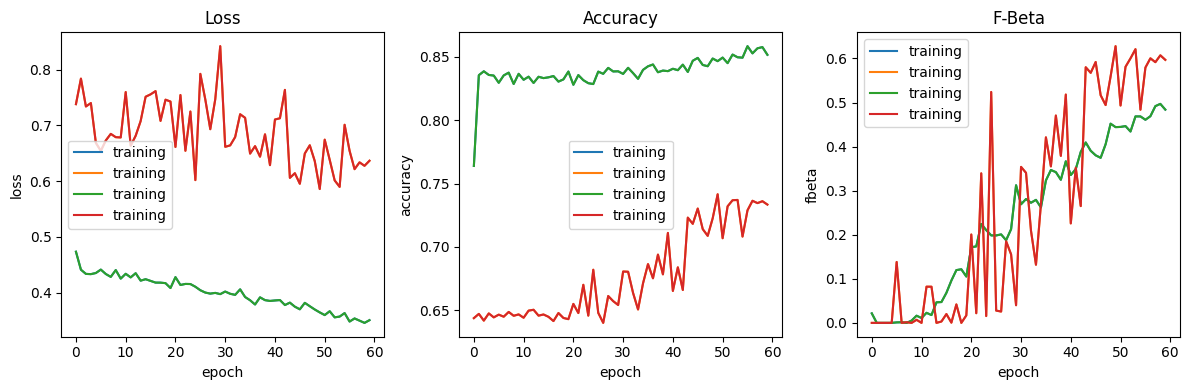

In [11]:
from utils import Trainer

if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD
    trainer = Trainer(model, train_loader, val_loader, optimizer, criterion, LEARNING_RATE)
    
    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

else:
    model_weights = torch.load(MODEL_SAVE_PATH)
    model.load_state_dict(model_weights)

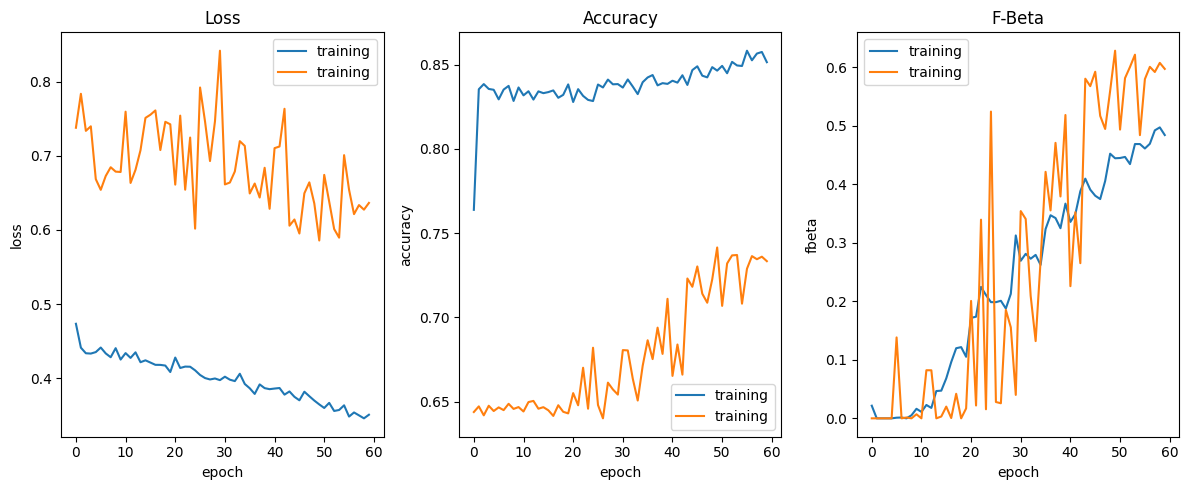

In [14]:
if TRAIN_RUN:
    plt.figure(figsize=(12, 5))
    trainer.plot_metrics()

I trained this for 15 minutes (30000 epochs). Judging by these graphs, it had not finished converging. I will try to train it for longer when I get the chance.

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20833/20833 [02:18<00:00, 150.59it/s]


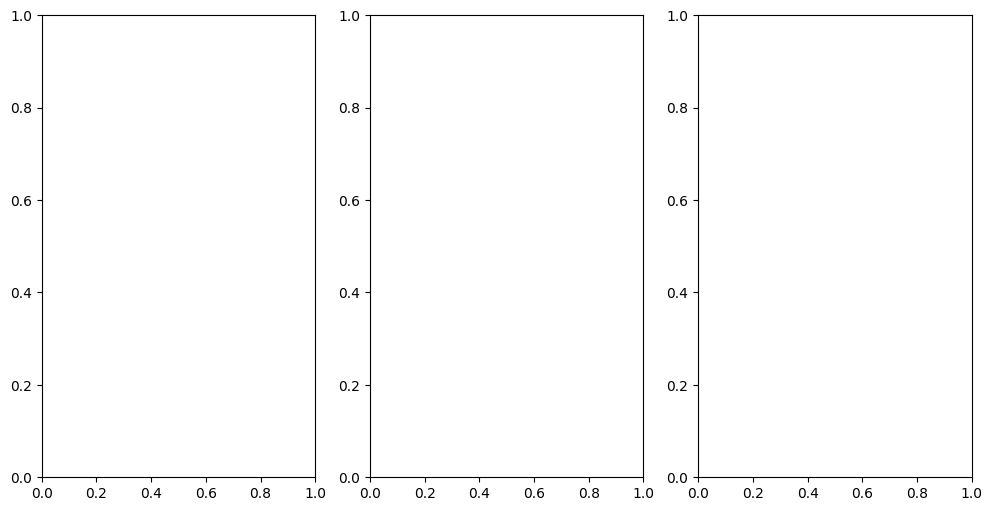

In [15]:
# View output on validation set
pred_images = []
model.eval()

for i in range(3):
    val_dset = val_dsets[i]
    val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
    outputs = []
    with torch.no_grad():
        for subvolumes, _ in tqdm(val_loader):
            output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
            outputs.append(output)
    image_shape = val_dset.image_stack[0].shape
    del val_loader
    gc.collect()

    pred_image = np.zeros(image_shape, dtype=np.uint8)
    outputs = np.concatenate(outputs)
    for (y, x), prob in zip(val_dset.pixels[:outputs.shape[0]], outputs):
        pred_image[y ,x] = prob > 0.4
    pred_images.append(pred_image)


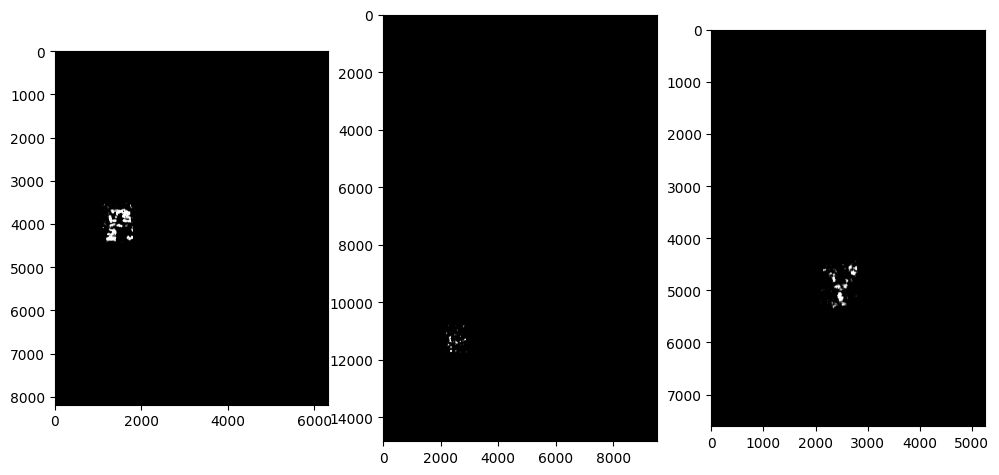

In [16]:
plt.subplots(1, 3, figsize=(12, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(pred_images[i], cmap='gray')

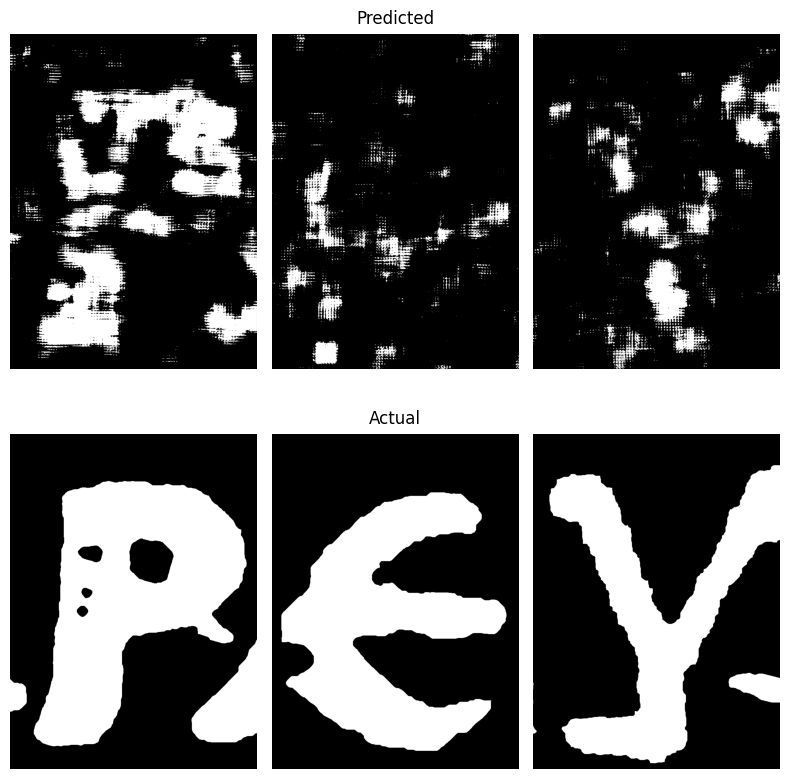

In [41]:
# close-up comparison
fig = plt.figure(figsize=(8, 8), tight_layout=True)
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigs[0].suptitle('Predicted')
axs = subfigs[0].subplots(nrows=1, ncols=3)
for i in range(3):
    rect = VALIDATION_RECTS[i]
    axs[i].imshow(pred_images[i], cmap='gray')
    axs[i].set_xlim([rect[0], rect[0]+rect[2]])
    axs[i].set_ylim([rect[1]+rect[3], rect[1]])
    axs[i].axis('off')
    
subfigs[1].suptitle('Actual')
axs = subfigs[1].subplots(nrows=1, ncols=3)
for i in range(3):
    rect = VALIDATION_RECTS[i]
    label = np.array(Image.open(TRAIN_PREFIX + f"{i+1}/inklabels.png"))
    axs[i].imshow(label, cmap='gray')
    axs[i].set_xlim([rect[0], rect[0]+rect[2]])
    axs[i].set_ylim([rect[1]+rect[3], rect[1]])
    axs[i].axis('off')



**Question:** On fragments 1 and 3, the letter shape is at least recognizable, but not on fragment 2. Any idea why that would be?

### Evaluate

In [43]:
dir()

['BASE_PREFIX',
 'BATCH_SIZE',
 'BUFFER',
 'DEVICE',
 'Dict',
 'Image',
 'In',
 'InkDetector',
 'LEARNING_RATE',
 'List',
 'MODEL_SAVE_PATH',
 'Optional',
 'Out',
 'PREFIX',
 'Path',
 'SimpleNamespace',
 'SubvolumeDataset',
 'TRAINING_EPOCHS',
 'TRAIN_RUN',
 'Trainer',
 'Tuple',
 'UndefinedMetricWarning',
 'VALIDATION_EPOCHS',
 'VALIDATION_RECTS',
 'Z_DIM',
 'Z_START',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__session__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'arr_mask',
 'ax',
 'axs',
 'criterion',
 'data',
 'defaultdic

In [46]:
# Clear memory before loading test fragments
del val_dset, val_dsets
gc.collect()

74491

In [52]:
test_path = Path(TEST_PREFIX)
test_fragments = list(test_path.iterdir())
print("All fragments:", test_fragments)

All fragments: [PosixPath('data/test/a'), PosixPath('data/test/b')]


### Submission

In [ ]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
pd.DataFrame.from_dict(submission)